In [37]:
import h5py
import numpy as np
import os
import pandas as pd
import scipy
import subprocess
import time

from os import listdir
from os.path import isfile, join

import bacco
import baccoemu

import matplotlib
from matplotlib import pyplot as plt

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 20

#matplotlib.rc('text', usetex=True)

## Bacco setup

In [3]:
##### DEFINE QUIJOTE COSMOLOGY ############
# The cosmology is not really needed but
# bacco P(k) corrects some modes according
# to their cosmology, so better have it
# just in case

a_Quijote = 1
Ob = 0.049
Om = 0.3175
hubble = 0.6711
ns = 0.9624
sigma8 = 0.834
cosmopars = dict(
        omega_cdm=Om-Ob,
        omega_baryon=Ob, 
        hubble=hubble, 
        ns=ns, 
        sigma8=sigma8,
        #tau=0.0561,
        A_s=None,
        neutrino_mass=0.,
        w0=-1,
        wa=0,
        tag="cosmo_BOSS"
    )
    
    
cosmo_Quijote = bacco.Cosmology(**cosmopars)
cosmo_Quijote.set_expfactor(a_Quijote)

2023-12-29 16:01:37,122 bacco.cosmo :    initialization took 0.000 secs


In [4]:
ngrid = 256 #1024 #512 #256 #128 #256 #1400
#nmean=0.01 not used
BoxSize=100/hubble
print(BoxSize)

bacco.configuration.update({'pknbody' : {'ngrid'  :  ngrid}})
bacco.configuration.update({'pknbody' : {'log_binning' : True}})
bacco.configuration.update({'pknbody' : {'log_binning_kmax' : 0.99506136}})#
bacco.configuration.update({'pknbody' : {'log_binning_nbins' : 100}})
bacco.configuration.update({'pknbody' : {'min_k' : 0.01721049}})
bacco.configuration.update({'pk' : {'maxk' : 0.99506136}}) 
bacco.configuration.update({'pknbody' : {'interlacing' : True}})

bacco.configuration.update({'pknbody' : {'depmethod' : 'cic'}})

bacco.configuration.update({'nonlinear' : {'concentration' : 'ludlow16'}})

bacco.configuration.update({'number_of_threads' : 12})
bacco.configuration.update({'scaling' : {'disp_ngrid' : ngrid}})

bacco.configuration.update({'pk':{'boltzmann_solver': 'CLASS'}})

149.0090895544628


## Load SAM data from hdf5 files

In [5]:
redshift = 0
dir_dat = '/lscratch/kstoreyf/CAMELS-SAM_data'

In [6]:
fns_dat = [join(dir_dat, f) for f in listdir(dir_dat) if isfile(join(dir_dat, f))]
#idx_sam = 0
#fns_dat = [f'{dir_dat}/LH_{idx_sam}_galprops_z{redshift}.hdf5']

In [7]:
n_sams = len(fns_dat)

## Load PROVABGS data

Downloaded from https://zenodo.org/records/8018936

In [8]:
# probabilistic SMFs
fn_psmf_bgs_q = '../data/data_provabgs/psmf.sv3.bgs_bright_q.z0.01_0.05.dat'
ms, psmf_bgs_q_mean, psmf_bgs_q_std = np.loadtxt(fn_psmf_bgs_q, unpack=True)

fn_psmf_bgs_sf = '../data/data_provabgs/psmf.sv3.bgs_bright_sf.z0.01_0.05.dat'
ms, psmf_bgs_sf_mean, psmf_bgs_sf_std = np.loadtxt(fn_psmf_bgs_sf, unpack=True)

In [9]:
# combine sf and q (star-forming and quiescent)
psmf_bgs_mean = psmf_bgs_sf_mean + psmf_bgs_q_mean
psmf_bgs_std = np.sqrt(psmf_bgs_sf_std**2 + psmf_bgs_q_std**2)

In [10]:
# standard (non-probabilistic) SMF, as check
fn_smf_bgs = '../data/data_provabgs/smf.standard.sv3.bgs_bright.z0.01_0.05.dat'
ms_smf, smf_bgs = np.loadtxt(fn_smf_bgs, unpack=True)

## Plot CAMELS SMFs

In [11]:
log_mass_shift = 9
h = 0.6711 # from perez et al
print(h**3)
vol_Mpc = (100/h)**3 # 100 Mpc/h = 100/h Mpc
vol_hMpc = 100**3 # units Mpc/h!! to match bgs; diff than plotted in camels paper
print(vol_Mpc, vol_hMpc)

0.302246803431
3308554.428527777 1000000


In [12]:
edges = np.linspace(8, 12.5, 40)

bin_width = edges[1] - edges[0]                
bins_avg = edges[0:-1] + bin_width/2.           

In [13]:
smf_arr = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        mstar_raw = np.array(f['mstar'])
        log_mstar = np.log10(mstar_raw) + log_mass_shift
        
        phi, edges = np.histogram(log_mstar, bins=edges)   
        smf = phi / vol_Mpc / bin_width
        smf_arr.append(smf)    

/tmp/ipykernel_70456/1712186730.py:6: RuntimeWarning: divide by zero encountered in log10
  log_mstar = np.log10(mstar_raw) + log_mass_shift


In [14]:
def get_distance_sigma(x1, y1, yerr1, x2, y2, xrange):
    xmin, xmax = xrange

    y1 = y1[(x1>=xmin) & (x1<xmax)]
    yerr1 = yerr1[(x1>=xmin) & (x1<xmax)]
    y2 = y2[(x2>=xmin) & (x2<xmax)]

    x1 = x1[(x1>=xmin) & (x1<xmax)]
    x2 = x2[(x2>=xmin) & (x2<xmax)]
    
    # interpolate y2 to be at the same x-vals as x2/y2
    y2_interp = np.interp(x1, x2, y2)
    sigmas = (y2_interp - y1)/yerr1
    sigma_mean = np.mean(np.abs(sigmas))
    return sigma_mean

In [15]:
sigma_means = []
xrange = [8,11]
for i in range(n_sams):
    
    sigma_mean = get_distance_sigma(ms, psmf_bgs_mean, psmf_bgs_std, bins_avg, smf_arr[i], xrange)
    sigma_means.append(sigma_mean)
sigma_means = np.array(sigma_means)

In [16]:
locs_norm = matplotlib.colors.Normalize(np.min(sigma_means), np.max(sigma_means), len(sigma_means))
cmap = matplotlib.cm.get_cmap('cool_r')
colors = cmap(locs_norm(sigma_means))

/tmp/ipykernel_70456/431812615.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool_r')


(8.0, 12.5)

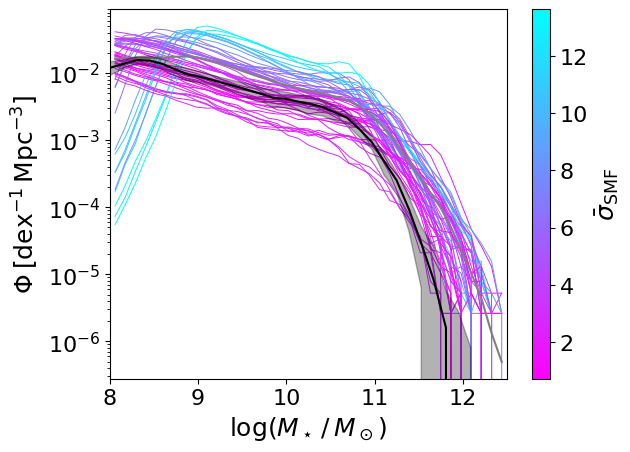

In [17]:
for i in range(n_sams):
    plt.plot(bins_avg, smf_arr[i], lw=0.7, color=colors[i])
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')

smf_mean = np.mean(smf_arr, axis=0)
smf_std = np.std(smf_arr, axis=0)
plt.plot(bins_avg, smf_mean, color='grey')
# plt.fill_between(bins_avg, 
#                  (smf_mean-smf_std), 
#                  (smf_mean+smf_std),
#                  color='magenta', alpha=0.3, lw=2,
#                  label='pSMF all')
    
plt.plot(ms, psmf_bgs_mean, color='black')
plt.fill_between(ms, 
                 psmf_bgs_mean-psmf_bgs_std, 
                 psmf_bgs_mean+psmf_bgs_std,
                 color='black', alpha=0.3,
                 zorder=10000,
                 label='BGS pSMF')
    
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi \: [\mathrm{dex}^{-1}\, \mathrm{Mpc}^{-3}]$')
plt.xlim(8, 12.5)

## Set up bacco P(k) code

In [18]:
args_power = {'ngrid':ngrid,
                  'box':BoxSize,
                  'cosmology':cosmo_Quijote,
                  'interlacing':True,
                  'kmin':0.1,
                  'kmax':1.0,
                  'nbins':16,
                  'correct_grid':True,
                  'log_binning':False,
                  'deposit_method':'cic',
                  'compute_correlation':False,
                  'zspace':False,
                  'normalise_grid': True,
                  'compute_power2d':False}

In [19]:
import logging
logger = logging.getLogger("bacco.power")
# only log really bad events
logger.setLevel(logging.ERROR)

In [20]:
pks = []
for i in range(n_sams):
    fn_dat = fns_dat[i]
    with h5py.File(fn_dat, 'r') as f:
        x_arr, y_arr, z_arr = f['x_position'], f['y_position'], f['z_position']
        pos_arr = np.array([x_arr, y_arr, z_arr]).T
        pk = bacco.statistics.compute_powerspectrum(pos=pos_arr, **args_power)
        pks.append(pk)

2023-12-29 16:01:38,945 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:39,414 bacco.cosmo :    computed CAMB power spectrum at z=0.00 in 0.216 secs
2023-12-29 16:01:39,430 bacco.cosmo :    created Pk(z=0) tab from k 7.450454722857103e-05 to 100000.0 h/Mpc
2023-12-29 16:01:39,436 bacco.cosmo :    computed halofit at z=0.00 for 'cosmo_BOSS' in 0.001 secs
2023-12-29 16:01:39,450 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:39,451 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:39,453 bacco.statistics : starting deposit 1
2023-12-29 16:01:39,544 bacco.statistics :  mesh done in 0.093 s
2023-12-29 16:01:39,545 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:39,740 bacco.statistics :  done compute.power
2023-12-29 16:01:39,741 bacco.statistics :  power done in 0.796 s
2023-12-29 16:01:39,769 bacco.statistics : Computing the power spectrum with ngrid=

bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 167652 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 167652 (grid1) 167652 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062723 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.074708 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000100 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 171268 particles (1 wit

2023-12-29 16:01:41,367 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:41,369 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:41,369 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:41,371 bacco.statistics : starting deposit 1
2023-12-29 16:01:41,462 bacco.statistics :  mesh done in 0.0922 s
2023-12-29 16:01:41,462 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:41,675 bacco.statistics :  done compute.power
2023-12-29 16:01:41,677 bacco.statistics :  power done in 0.309 s
2023-12-29 16:01:41,702 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:41,706 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:41,706 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:41,707 bacco.statistics : starting deposit 1
2023-12-29 16:01:41,798 bacco.statistics :  m

actor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 188395 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 188395 (grid1) 188395 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.058008 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.069515 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000272 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 178582 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxs

2023-12-29 16:01:43,091 bacco.statistics :  done compute.power
2023-12-29 16:01:43,093 bacco.statistics :  power done in 0.299 s
2023-12-29 16:01:43,116 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:43,118 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:43,118 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:43,119 bacco.statistics : starting deposit 1
2023-12-29 16:01:43,217 bacco.statistics :  mesh done in 0.0993 s
2023-12-29 16:01:43,218 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:43,407 bacco.statistics :  done compute.power
2023-12-29 16:01:43,409 bacco.statistics :  power done in 0.293 s
2023-12-29 16:01:43,435 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:43,437 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:43,437 bacco.statistics : Computing cic mesh with ngrid=256

h : allocating 128.0 Mb
bacco.mesh : binning of 162100 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 162100 (grid1) 162100 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.062977 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.073152 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000142 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 167083 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposi

2023-12-29 16:01:44,746 bacco.statistics :  done compute.power
2023-12-29 16:01:44,747 bacco.statistics :  power done in 0.315 s
2023-12-29 16:01:44,773 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:44,774 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:44,775 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:44,776 bacco.statistics : starting deposit 1
2023-12-29 16:01:44,867 bacco.statistics :  mesh done in 0.0916 s
2023-12-29 16:01:44,868 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:45,051 bacco.statistics :  done compute.power
2023-12-29 16:01:45,054 bacco.statistics :  power done in 0.281 s
2023-12-29 16:01:45,086 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:45,088 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:45,088 bacco.statistics : Computing cic mesh with ngrid=256

les (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 182237 (grid1) 182237 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.057686 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079984 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000087 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 180121 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_

2023-12-29 16:01:46,766 bacco.statistics :  done compute.power
2023-12-29 16:01:46,769 bacco.statistics :  power done in 0.308 s
2023-12-29 16:01:46,794 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:46,796 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:46,796 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:46,798 bacco.statistics : starting deposit 1
2023-12-29 16:01:46,883 bacco.statistics :  mesh done in 0.0871 s
2023-12-29 16:01:46,884 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:47,095 bacco.statistics :  done compute.power
2023-12-29 16:01:47,096 bacco.statistics :  power done in 0.302 s
2023-12-29 16:01:47,122 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:47,124 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:47,126 bacco.statistics : Computing cic mesh with ngrid=256

wer : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 163174 (grid1) 163174 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061690 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.096487 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000210 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 168793 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 

2023-12-29 16:01:48,250 bacco.statistics :  mesh done in 0.0825 s
2023-12-29 16:01:48,251 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:48,473 bacco.statistics :  done compute.power
2023-12-29 16:01:48,483 bacco.statistics :  power done in 0.317 s
2023-12-29 16:01:48,517 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:48,519 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:48,520 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:48,521 bacco.statistics : starting deposit 1
2023-12-29 16:01:48,601 bacco.statistics :  mesh done in 0.0808 s
2023-12-29 16:01:48,602 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:48,815 bacco.statistics :  done compute.power
2023-12-29 16:01:48,816 bacco.statistics :  power done in 0.299 s
2023-12-29 16:01:48,843 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 173371 (grid1) 173371 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.061867 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.103278 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.004215 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 158633 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco

2023-12-29 16:01:49,933 bacco.statistics :  mesh done in 0.0876 s
2023-12-29 16:01:49,934 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:50,166 bacco.statistics :  done compute.power
2023-12-29 16:01:50,167 bacco.statistics :  power done in 0.325 s
2023-12-29 16:01:50,194 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:50,198 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:50,199 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:50,204 bacco.statistics : starting deposit 1
2023-12-29 16:01:50,287 bacco.statistics :  mesh done in 0.088 s
2023-12-29 16:01:50,288 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:50,507 bacco.statistics :  done compute.power
2023-12-29 16:01:50,507 bacco.statistics :  power done in 0.314 s
2023-12-29 16:01:50,532 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=Tr

; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 174972 (grid1) 174972 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.058430 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.073038 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000166 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 178313 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 178313 (grid1) 178313 (grid2)
bacco.power

2023-12-29 16:01:51,643 bacco.statistics :  mesh done in 0.0825 s
2023-12-29 16:01:51,645 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:51,888 bacco.statistics :  done compute.power
2023-12-29 16:01:51,889 bacco.statistics :  power done in 0.334 s
2023-12-29 16:01:51,918 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:51,920 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:51,921 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:51,922 bacco.statistics : starting deposit 1
2023-12-29 16:01:51,999 bacco.statistics :  mesh done in 0.0789 s
2023-12-29 16:01:52,001 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:52,219 bacco.statistics :  done compute.power
2023-12-29 16:01:52,220 bacco.statistics :  power done in 0.301 s
2023-12-29 16:01:52,249 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

e_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 161996 (grid1) 161996 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.056307 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.095356 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000096 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 169629 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 169629 (grid1) 169629 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.065979 sec
bacco.power 

2023-12-29 16:01:53,321 bacco.statistics :  mesh done in 0.0924 s
2023-12-29 16:01:53,321 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:53,530 bacco.statistics :  done compute.power
2023-12-29 16:01:53,531 bacco.statistics :  power done in 0.305 s
2023-12-29 16:01:53,559 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:53,560 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:53,561 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:53,562 bacco.statistics : starting deposit 1
2023-12-29 16:01:53,656 bacco.statistics :  mesh done in 0.0948 s
2023-12-29 16:01:53,658 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:53,872 bacco.statistics :  done compute.power
2023-12-29 16:01:53,873 bacco.statistics :  power done in 0.314 s
2023-12-29 16:01:53,896 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

d2=1
bacco.power : total mass 162971 (grid1) 162971 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.056753 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.075848 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000109 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 163734 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 163734 (grid1) 163734 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.068285 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.07641

2023-12-29 16:01:55,009 bacco.statistics :  mesh done in 0.0868 s
2023-12-29 16:01:55,010 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:55,229 bacco.statistics :  done compute.power
2023-12-29 16:01:55,230 bacco.statistics :  power done in 0.311 s
2023-12-29 16:01:55,257 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:55,259 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:55,262 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:55,264 bacco.statistics : starting deposit 1
2023-12-29 16:01:55,353 bacco.statistics :  mesh done in 0.0905 s
2023-12-29 16:01:55,354 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:55,551 bacco.statistics :  done compute.power
2023-12-29 16:01:55,552 bacco.statistics :  power done in 0.296 s
2023-12-29 16:01:55,580 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=T

acco.power : Doing FFTW
bacco.power: FFT took 0.062182 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.068777 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000104 secs
bacco.power : Deallocating arrays
bacco.mesh : boxsize=149.009094 ngrid=256, nthreads=12, vel_factor=0.000000, interlacing=1, folds=1.000000, 2d=0
bacco.mesh : allocating 128.0 Mb
bacco.mesh : binning of 172335 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 149.009094; ngrid 256; nthreads 12; interlacing 1; deposit_method 1; log_binning 0; type 0; precision=single; correct_grid=1 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=1 deconvolve_grid2=1
bacco.power : total mass 172335 (grid1) 172335 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.057751 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.088154 sec
bacco.power : Starting Fourier loop 
bacco.power : done

2023-12-29 16:01:56,702 bacco.statistics :  mesh done in 0.0875 s
2023-12-29 16:01:56,703 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:56,907 bacco.statistics :  done compute.power
2023-12-29 16:01:56,908 bacco.statistics :  power done in 0.297 s
2023-12-29 16:01:56,932 bacco.statistics : Computing the power spectrum with ngrid=256 and interlacing=True
2023-12-29 16:01:56,935 bacco.statistics :  setting the grid 256 True
2023-12-29 16:01:56,936 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=True
2023-12-29 16:01:56,937 bacco.statistics : starting deposit 1
2023-12-29 16:01:57,028 bacco.statistics :  mesh done in 0.0926 s
2023-12-29 16:01:57,029 bacco.statistics :  Starting the power spectrum calculation
2023-12-29 16:01:57,217 bacco.statistics :  done compute.power
2023-12-29 16:01:57,218 bacco.statistics :  power done in 0.286 s


Text(0, 0.5, '$P(k)$')

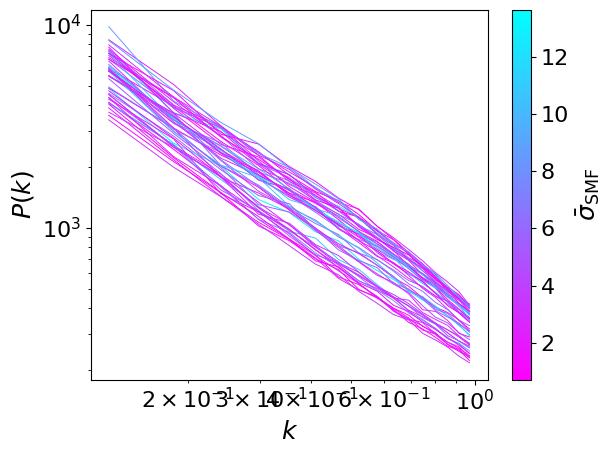

In [21]:
for i in range(n_sams):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    
ax = plt.gca()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=locs_norm)
plt.colorbar(sm, ax=ax, label=r'$\bar{\sigma}_\text{SMF}$')
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

In [40]:
k_sam_all = pks[0]['k'] # same for all 

## Load bacco emu

In [22]:
emulator = baccoemu.Lbias_expansion()

Loading l-bias lpt emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when u

L-bias lpt emulator loaded in memory.
Loading smeared bao emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Smeared bao emulator loaded in memory.
Loading non-linear l-bias emulator...


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Nonlinear l-bias emulator loaded in memory.
Loading sigma8 emulator...
Sigma8 emulator loaded in memory.
Loading no-wiggles emulator...
No-wiggles emulator loaded in memory.


/dipc/kstoreyf/.conda/envs/baccoenv/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
#k = np.logspace(-1.9, np.log10(emulator.emulator['nonlinear']['k'].max()), num=100)

In [24]:
# should this match camels??
params = {
    'omega_cold'    :  Om,
    'sigma8_cold'   :  sigma8, # if A_s is not specified
    'omega_baryon'  :  Ob,
    'ns'            :  ns,
    'hubble'        :  hubble,
    'neutrino_mass' :  0.0,
    'w0'            : -1.0,
    'wa'            :  0.0,
    'expfactor'     :  1
}

In [25]:
#k, pnn = emulator.get_nonlinear_pnn(k=k, **params)

### Fit bias params

In [62]:
def ln_like(bias_params, k_data, p_data, C_inv):
    _, p_gg, _ = emulator.get_galaxy_real_pk(bias=bias_params, k=k_data, **params)
    delta_y = p_data - p_gg
    lnlk = 0.5 * delta_y.T @ C_inv @ delta_y
    return lnlk

In [69]:
i_bins = k_sam_all < 0.75
k_sam = k_sam_all[i_bins]
C_inv = np.diag(np.ones(len(k_sam))/len(k_sam))

In [75]:
bias_param_names = ['b1', 'b2', 'bs2', 'bl']
bias_param_labels = {'b1': r'$b_1$', 
                     'b2': r'$b_2$', 
                     'bs2': r'$b_{s^2}$', 
                     'bl': r'$b_{\nabla^2 \delta}$',
                    }
bias_bounds = {'b1': [-0.25, 1.75],
               'b2': [-1, 2],
               'bs2': [-3, 1],
               'bl': [-5, 2],
              } 
bounds = [bias_bounds[bname] for bname in bias_param_names]

[[-0.25, 1.75], [-1, 2], [-3, 1], [-5, 2]]


In [70]:
n_fit = 10

In [71]:
bias_params_0 = [0.5, 0.5, 1.0, -1.0]
res_arr = []
for i in range(n_fit):
    print(f"Fitting SAM {i}")
    p_sam = pks[i]['pk'][i_bins]
    res = scipy.optimize.minimize(ln_like, bias_params_0, bounds=bounds, args=(k_sam, p_sam, C_inv))
    res_arr.append(res)

Fitting SAM 0
Fitting SAM 1
Fitting SAM 2
Fitting SAM 3
Fitting SAM 4
Fitting SAM 5
Fitting SAM 6
Fitting SAM 7
Fitting SAM 8
Fitting SAM 9


In [72]:
print(np.sum([res['success'] for res in res_arr]))

10


Text(0, 0.5, '$P(k)$')

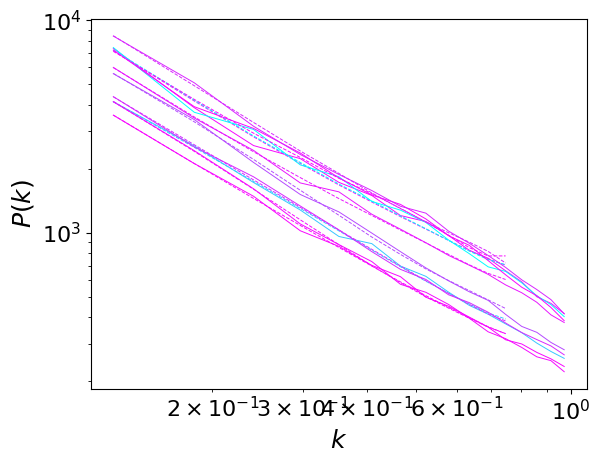

In [74]:
for i in range(n_fit):
    plt.plot(pks[i]['k'], pks[i]['pk'], lw=0.7, color=colors[i])
    _, pk_emu, _ = emulator.get_galaxy_real_pk(bias=res_arr[i]['x'], k=k_sam, **params)
    plt.plot(k_sam, pk_emu, lw=0.7, ls='--', color=colors[i])

    
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$')
plt.ylabel(r'$P(k)$')

## Plot bias params

Text(0.5, 0, '$b_1$')

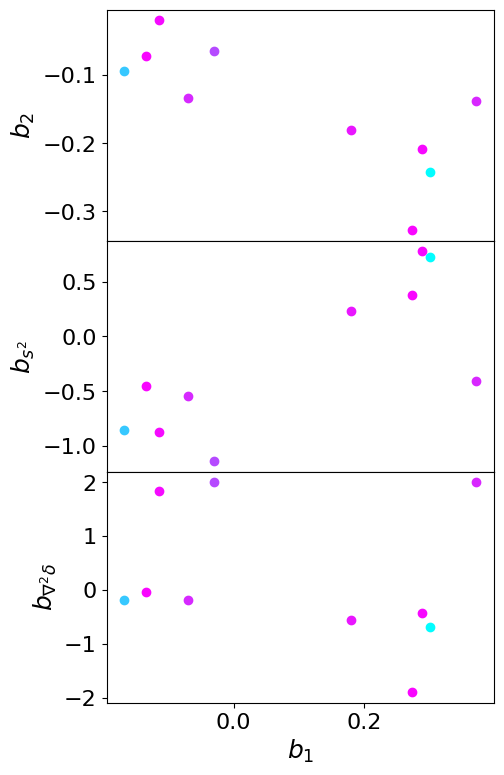

In [81]:
nrows, ncols = 3, 1
fig, axarr = plt.subplots(nrows, ncols, figsize=(5, 3*nrows), sharex=True)
plt.subplots_adjust(hspace=0)

for i in range(n_fit):
    bias_params = res_arr[i]['x']
    for bb in range(1,len(bias_param_names)):
        axarr[bb-1].plot(bias_params[0], bias_params[bb], marker='o', markersize=6, color=colors[i])
        axarr[bb-1].set_ylabel(bias_param_labels[bias_param_names[bb]])

plt.xlabel(bias_param_labels[bias_param_names[0]])